In [126]:
import os,sys
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from data_aug.data_aug import * # https://github.com/Paperspace/DataAugmentationForObjectDetection
from data_aug.bbox_util import *
import numpy as np 
import random
import cv2 
import tqdm
import matplotlib.pyplot as plt 
import multiprocessing as mp
import pickle as pkl
from glob import glob
import itertools
%matplotlib inline

from database import Database
class YOLODataAug(Database):
    # Initializer
    def __init__(self, dataset_location, database_location, site):
        super().__init__(dataset_location, database_location, site)
            
    def bbox_norm_to_index(self,data,label):
        """Convert normalised yolo label format to data_aug label format
        YOLO: [c,x,y,w,h] --> DATA_AUG: [x1,y1,x2,y2,c]
        Param
            data: rgb jpg data, (x,y,c)
            label: YOLO format [c,x,y,w,h]"""
        f_size, t_size, _ = data.shape
        bbox = []
        for l in label:
            c = l[0]
            x1 = int((l[1]-l[3]/2)*t_size)
            x2 = int((l[1]+l[3]/2)*t_size)
            y1 = int((l[2]-l[4]/2)*f_size)
            y2 = int((l[2]+l[4]/2)*f_size)
            bbox.append([x1,y1,x2,y2,c])
        return np.array(bbox, dtype=np.float32)
    
    def bbox_index_to_norm(self,data,label):
        """Convert data_aug label format to normalised yolo label format
        DATA_AUG: [x1,y1,x2,y2,c] --> YOLO: [c,x,y,w,h]
        Param
            data: rgb jpg data, (x,y,c)
            label: DATA_AUG: [x1,y1,x2,y2,c]"""
        f_size, t_size, _ = data.shape
        bbox = []
        for l in label:
            c = l[-1]
            x = abs((l[2]+l[0])/(2*t_size))
            y = abs((l[3]+l[1])/(2*f_size))
            w = abs((l[2]-l[0])/t_size)
            h = abs((l[3]-l[1])/(f_size))
            bbox.append([c,x,y,w,h])
        return np.array(bbox, dtype=np.float32)
    
    def data_aug(self, file, transforms):
        """Augment the data in file based on the transform"""
        img, bboxes = self.load_yolo_file(file)
        bboxes = self.bbox_norm_to_index(img,bboxes)
        for transform in transforms:
            if transform=='flip':
                img, bboxes = RandomHorizontalFlip(1)(img, bboxes)
            elif transform=='scale':
                img, bboxes = RandomScale(0.2)(img, bboxes)
            elif transform=='translate':
                img, bboxes = RandomTranslate(0.3, diff = False)(img, bboxes)
            elif transform=='rotate':
                img, bboxes =  RandomRotate(5)(img, bboxes)
        return img, bboxes
    
    def data_aug_file(self, file, path, transforms):
        """Save augmented data"""
        img, bboxes = self.data_aug(file, transforms)
        bboxes = self.bbox_index_to_norm(img, bboxes)
        title, ext = os.path.splitext(os.path.basename(file))
        title += '_'+str(transforms)
        cv2.imwrite(os.path.join(path,title)+'.jpg', img)
        # save label
        label_file = os.path.join(os.path.join(path,title)+'.txt')
        with open(label_file, "w") as text_file:
            for bbox in bboxes:
                text_file.write(' '.join([str(e) for e in bbox])+'\n')
                
    def data_aug_file_(self, params):
        self.data_aug_file(file=params[0], path=params[1], transforms=params[2])
        
    def transforms_permutation(self, transforms, r=2):
        """Generate permutations of the transforms"""
        t = list(itertools.permutations(transforms,1))
        for ix in range(2,r+1):
            t += list(itertools.permutations(transforms,ix))
        return t
    
    def generate_aug_data(self, transforms):
        """Generate all augmented yolo file with the transforms
        Param
            transforms: list of transforms 
        """
        files = self.get_samples()
        path = os.path.join(self.get_database_location(),self.get_site(), 'yolo', 'data')
        try:
            os.makedirs(path)
        except OSError:
            pass
        # use multiprocessing
        pool = mp.Pool(mp.cpu_count())
        params = [[file, path, transform] for file in files for transform in self.transforms_permutation(transforms)] # define parameters
        for _ in tqdm.tqdm(pool.imap_unordered(self.data_aug_file_, params), total=len(params)):
            pass
        pool.close()
    
    def yolo_aug_data_split(self, transforms):
        """Split yolo data based on intitial train test split
        Param
            transforms: the transforms used for the augmentation"""
        train_files, test_files = self.get_train(), self.get_test()
        path = os.path.join(self.get_database_location(),self.get_site(), 'yolo')
        comb_transforms = self.transforms_permutation(transforms)
        with open(os.path.join(path,'train_aug.txt'), 'w') as f:
            for file in train_files:
                title, ext = os.path.splitext(os.path.basename(file))
                f.write(os.path.join(path,'data',title)+'.jpg' +os.linesep)
                for transform in comb_transforms:
                    f.write(os.path.join(path,'data',title+'_'+str(transform))+'.jpg' +os.linesep)
        with open(os.path.join(path,'test_aug.txt'), 'w') as f:
            for file in test_files:
                title, ext = os.path.splitext(os.path.basename(file))
                f.write(os.path.join(path,'data',title)+'.jpg' +os.linesep)
                for transform in comb_transforms:
                    f.write(os.path.join(path,'data',title+'_'+str(transform))+'.jpg' +os.linesep)

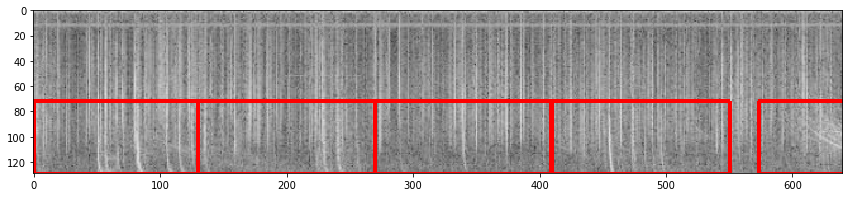

100%|██████████| 5/5 [00:00<00:00, 804.96it/s]


In [128]:
# from database import Database
# dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
# site = 'marion'
# yolo_aug = YOLODataAug(dataset_loc, database_loc, site)
# file = yolo_aug.get_random_yolo()
# transforms = ['flip', 'rotate', 'scale', 'translate']
# new_transforms = yolo_aug.transforms_permutation(transforms)

# img, bboxes = yolo_aug.data_aug(file, random.choice(new_transforms))
# plt.subplots(1, figsize=(16,3))
# plotted_img = draw_rect(img, bboxes, color=(255,0,0),thickness=2)
# plt.imshow(plotted_img)
# plt.show()
# # yolo_aug.data_aug_file(file, transforms)
# # yolo_aug.generate_aug_data(transforms)
# # yolo_aug.yolo_aug_data_split(transforms)

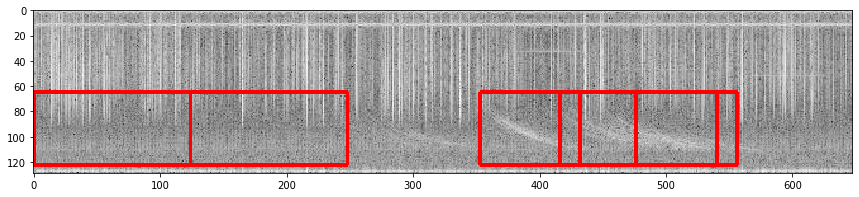

In [57]:
# from database import Database
# dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
# site = 'marion'
# yolo_aug = YOLODataAug(dataset_loc, database_loc, site)
# img, bboxes = yolo_aug.load_yolo_file(yolo_aug.get_random_yolo())
# bboxes = yolo_aug.bbox_norm_to_index(img,bboxes)
# plt.subplots(1, figsize=(16,3))
# plotted_img = draw_rect(img, bboxes, color=(255,0,0),thickness=2)
# plt.imshow(plotted_img)
# plt.show()

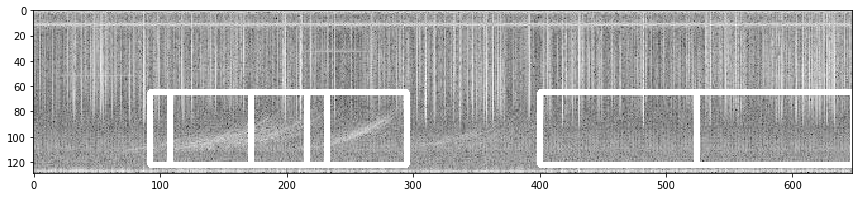

[[178.  65. 302. 122.   1.]
 [516.  65. 640. 122.   0.]
 [392.  65. 516. 122.   0.]
 [ 54.  65. 179. 122.   0.]]


In [66]:
# img, bboxes = RandomHorizontalFlip(1)(img, bboxes)
# plotted_img = draw_rect(img, bboxes)
# plt.subplots(1, figsize=(16,3))
# plt.imshow(plotted_img)
# plt.show()
# print(bboxes_)

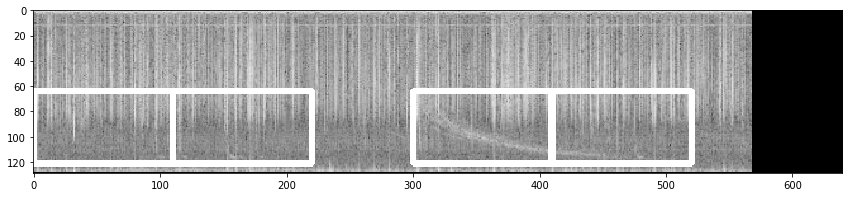

[[300.4508    64.84042  410.67535  121.70049    1.      ]
 [  0.        64.84042  110.224556 121.70049    0.      ]
 [110.224556  64.84042  220.44911  121.70049    0.      ]
 [409.78644   64.84042  520.8999   121.70049    0.      ]]


In [27]:
# img_, bboxes_ = RandomScale(0.2, diff = True)(img.copy(), bboxes.copy())
# plt.subplots(1, figsize=(16,3))
# plotted_img = draw_rect(img_, bboxes_)
# plt.imshow(plotted_img)
# plt.show()
# print(bboxes_)

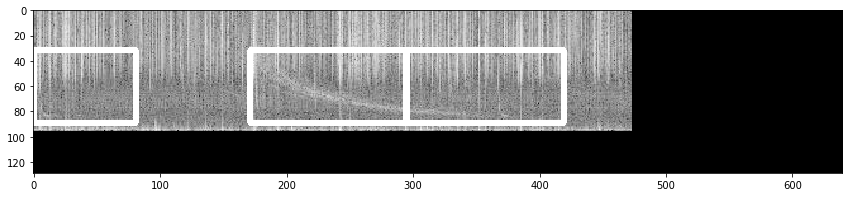

[[171.  32. 295.  89.   1.]
 [  0.  32.  81.  89.   0.]
 [294.  32. 419.  89.   0.]]


In [52]:
# img_, bboxes_ = RandomTranslate(0.3, diff = False)(img.copy(), bboxes.copy())
# plt.subplots(1, figsize=(16,3))
# plotted_img = draw_rect(img_, bboxes_)
# plt.imshow(plotted_img)
# plt.show()
# print(bboxes_)

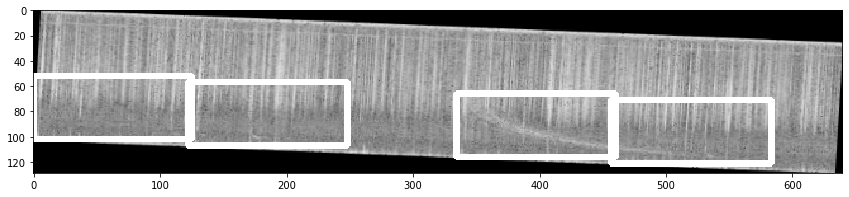

In [36]:
# img_, bboxes_ = RandomRotate(5)(img.copy(), bboxes.copy())
# plt.subplots(1, figsize=(16,3))
# plotted_img = draw_rect(img_, bboxes_)
# plt.imshow(plotted_img)
# plt.show()

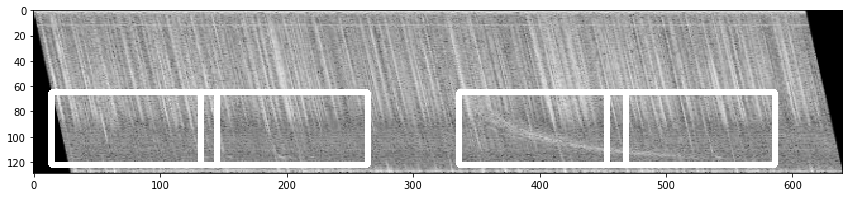

In [42]:
# img_, bboxes_ = RandomShear(0.9)(img.copy(), bboxes.copy())
# plt.subplots(1, figsize=(16,3))
# plotted_img = draw_rect(img_, bboxes_)
# plt.imshow(plotted_img)
# plt.show()

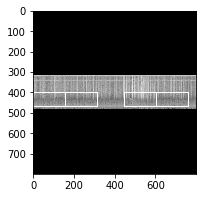

In [105]:
# img_, bboxes_ = Resize(800)(img.copy(), bboxes.copy())
# plt.subplots(1, figsize=(16,3))
# plotted_img = draw_rect(img_, bboxes_)
# plt.imshow(plotted_img)
# plt.show()

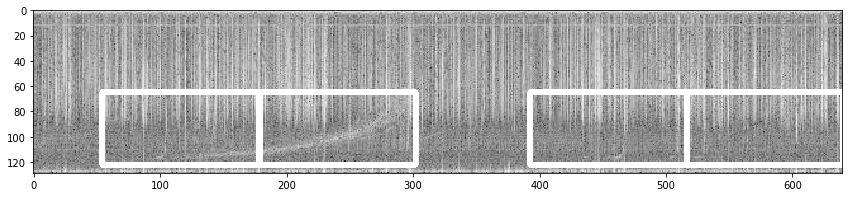

In [55]:
# seq = Sequence([RandomHorizontalFlip(1)])#, RandomScale(), RandomTranslate(), RandomRotate(2)])
# img_, bboxes_ = seq(img.copy(), bboxes.copy())
# plt.subplots(1, figsize=(16,3))
# plotted_img = draw_rect(img_, bboxes_)
# plt.imshow(plotted_img)
# plt.show()